# THỰC HÀNH: PHÂN LỚP LETTER RECOGNITION BẰNG THUẬT TOÁN KNN

Dataset: UCI Letter Recognition (20,000 samples — 26 classes)

## Mục tiêu:
- Hiểu dữ liệu Letter Recognition.
- Trực quan hóa và phân tích dữ liệu (EDA).
- Tiền xử lý dữ liệu.
- Chia train/test.
- Cài đặt KNN thủ công & đánh giá độ chính xác.
- Thử nghiệm nhiều giá trị k.
- So sánh với sklearn KNN.
- Đánh giá mô hình và kết luận.


#### Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


#### Load dữ liệu

In [2]:
df = pd.read_csv("letter+recognition/letter-recognition.data", header=None)
df.head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0  T   2   8   3   5   1   8  13   0   6   6  10   8   0   8   0   8
1  I   5  12   3   7   2  10   5   5   4  13   3   9   2   8   4  10
2  D   4  11   6   8   6  10   6   2   6  10   3   7   3   7   3   9
3  N   7  11   6   6   3   5   9   4   6   4   4  10   6  10   2   8
4  G   2   1   3   1   1   8   6   6   6   6   5   9   1   7   5  10

#### Thêm tên cột (theo file .names)

In [3]:
columns = [
    "letter", "x-box", "y-box", "width", "height", "onpix", 
    "xbar", "ybar", "x2bar", "y2bar", "xybar", "xegvy", 
    "xegvx", "yegvx", "yegvy", "x-ege", "y-ege"
]
df.columns = columns
df.head()


letter  x-box  y-box  width  height  onpix  xbar  ybar  x2bar  y2bar  xybar  \
0      T      2      8      3       5      1     8    13      0      6      6   
1      I      5     12      3       7      2    10     5      5      4     13   
2      D      4     11      6       8      6    10     6      2      6     10   
3      N      7     11      6       6      3     5     9      4      6      4   
4      G      2      1      3       1      1     8     6      6      6      6   

   xegvy  xegvx  yegvx  yegvy  x-ege  y-ege  
0     10      8      0      8      0      8  
1      3      9      2      8      4     10  
2      3      7      3      7      3      9  
3      4     10      6     10      2      8  
4      5      9      1      7      5     10

#### Thông tin tổng quan

In [4]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   x-box   20000 non-null  int64 
 2   y-box   20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  xegvy   20000 non-null  int64 
 12  xegvx   20000 non-null  int64 
 13  yegvx   20000 non-null  int64 
 14  yegvy   20000 non-null  int64 
 15  x-ege   20000 non-null  int64 
 16  y-ege   20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


letter    0
x-box     0
y-box     0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
xegvy     0
xegvx     0
yegvx     0
yegvy     0
x-ege     0
y-ege     0
dtype: int64

#### Phân bố số lượng từng chữ cái

In [5]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="letter")
plt.title("Distribution of Letters (A–Z)")
plt.show()


#### Heatmap tương quan feature

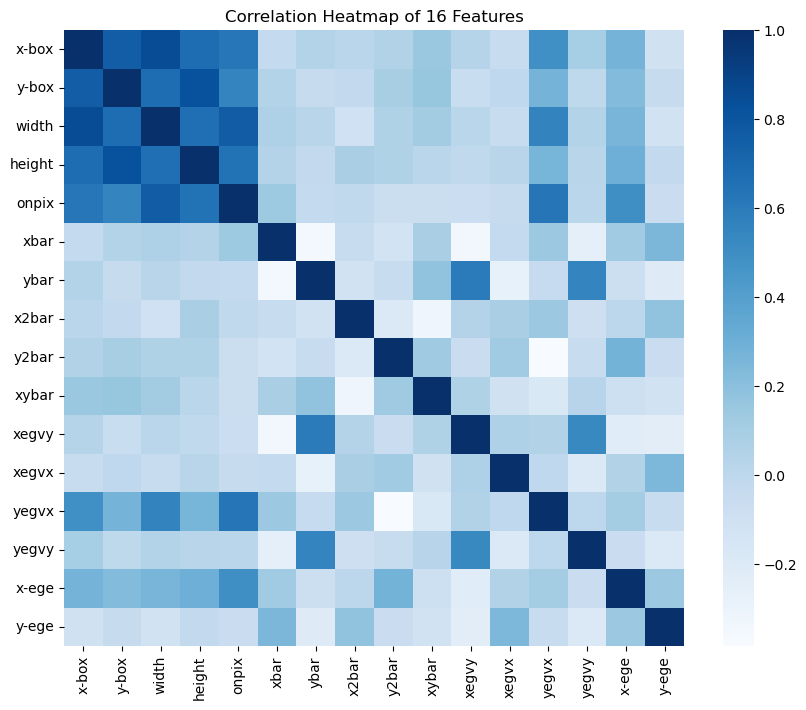

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.iloc[:, 1:].corr(), cmap="Blues")
plt.title("Correlation Heatmap of 16 Features")
plt.show()


#### Histogram các thuộc tính

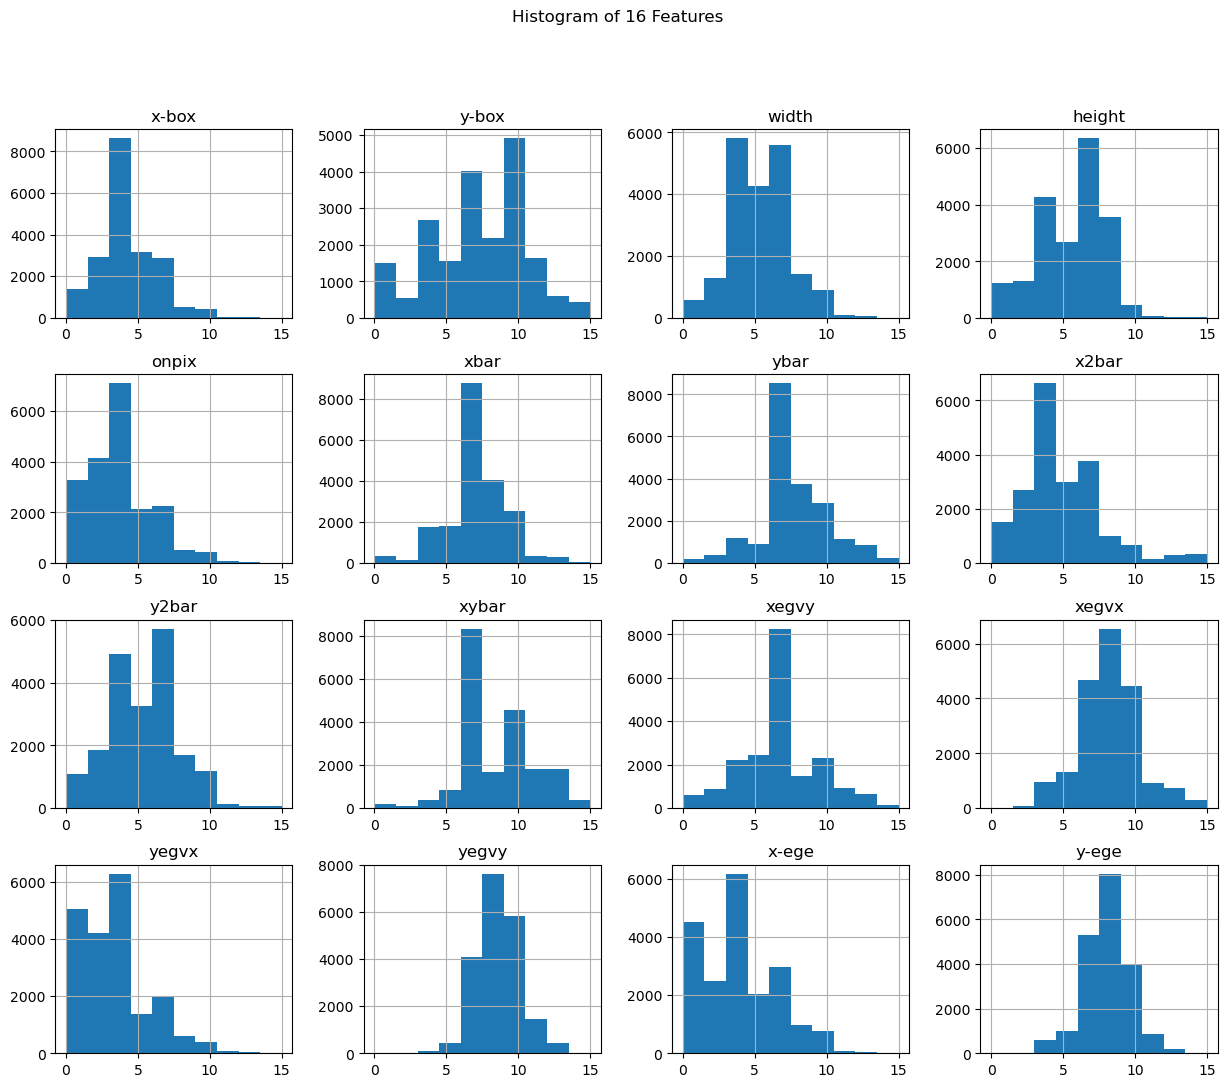

In [7]:
df.iloc[:, 1:].hist(figsize=(15,12))
plt.suptitle("Histogram of 16 Features")
plt.show()


#### Chuẩn bị dữ liệu (encode label)

In [8]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values


#### Chia train/test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

X_train.shape, X_test.shape


((16000, 16), (4000, 16))

#### Chuẩn hóa dữ liệu

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### PHẦN 2 — CÀI ĐẶT KNN THỦ CÔNG

#### KNN thủ công

In [11]:
class MyKNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict_one(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_idx = distances.argsort()[:self.k]
        k_labels = self.y_train[k_idx]
        label = Counter(k_labels).most_common(1)[0][0]
        return label
    
    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


#### Chạy thử nghiệm KNN thủ công


In [12]:
model = MyKNN(k=5)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
acc


0.94875

#### Kiểm tra nhiều giá trị k

In [13]:
k_values = range(1, 16)
accuracies = []

for k in k_values:
    knn = MyKNN(k=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred))

accuracies


[0.948,
 0.948,
 0.94975,
 0.95275,
 0.94875,
 0.9495,
 0.94275,
 0.94625,
 0.94175,
 0.9415,
 0.942,
 0.9415,
 0.94075,
 0.93725,
 0.936]

Đánh giá ảnh hưởng của tham số k đối với KNN thủ công

Trong thí nghiệm, mô hình KNN được chạy với k từ 1 đến 15. Accuracy thu được như sau:

Accuracy cao nhất đạt 95.275% tại k = 4.

Khi k tăng từ 1 → 4, accuracy có xu hướng tăng nhẹ.

Khi k > 6, accuracy bắt đầu giảm dần từ khoảng 94.2% xuống còn 93.6% khi k = 15.

Hiện tượng này phù hợp với lý thuyết:

Với k quá nhỏ, mô hình nhạy cảm với nhiễu trong dữ liệu, dẫn đến dự đoán sai với các điểm outlier.

Với k vừa phải (3–6), mô hình cân bằng tốt giữa độ mịn và khả năng phân biệt.

Với k lớn, mô hình mất tính cục bộ, dễ bị ảnh hưởng bởi các điểm thuộc lớp khác → accuracy giảm.

Giá trị k tối ưu tìm được là k = 4, cho accuracy cao nhất 95.275%.

#### Biểu đồ Accuracy vs. k

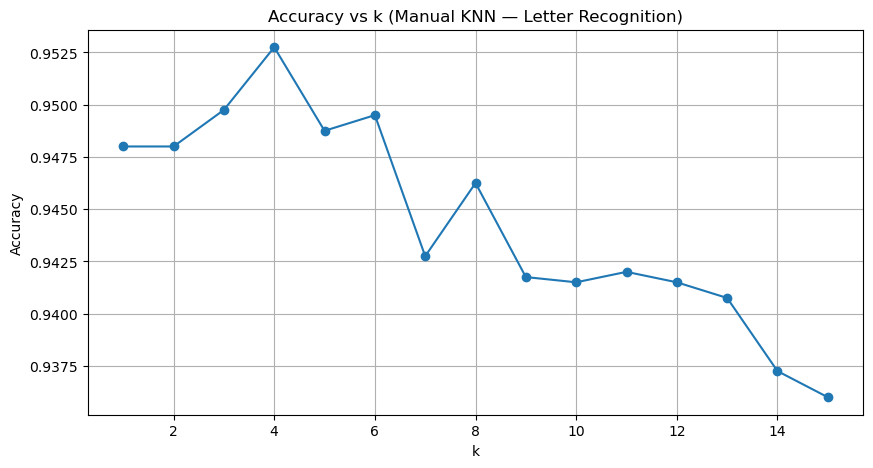

In [14]:
plt.figure(figsize=(10,5))
plt.plot(k_values, accuracies, marker="o")
plt.title("Accuracy vs k (Manual KNN — Letter Recognition)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


#### SO SÁNH VỚI SKLEARN

#### KNN sklearn

In [15]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_scaled, y_train)

y_pred_sklearn = clf.predict(X_test_scaled)

print("Sklearn Accuracy:", accuracy_score(y_test, y_pred_sklearn))


Sklearn Accuracy: 0.9425


d:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "d:\ProgramData\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "d:\ProgramData\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

#### Classification Report (sklearn)

In [16]:
print(classification_report(y_test, y_pred_sklearn))


              precision    recall  f1-score   support

           A       0.95      0.99      0.97       149
           B       0.87      0.97      0.91       153
           C       0.95      0.94      0.95       137
           D       0.86      0.97      0.92       156
           E       0.92      0.96      0.94       141
           F       0.89      0.93      0.91       140
           G       0.96      0.94      0.95       160
           H       0.88      0.78      0.83       144
           I       0.96      0.93      0.94       146
           J       0.94      0.96      0.95       149
           K       0.90      0.87      0.88       130
           L       0.98      0.97      0.98       155
           M       0.97      0.96      0.96       168
           N       0.95      0.93      0.94       151
           O       0.93      0.94      0.94       145
           P       0.98      0.92      0.95       173
           Q       0.97      0.95      0.96       166
           R       0.89    

#### Confusion Matrix

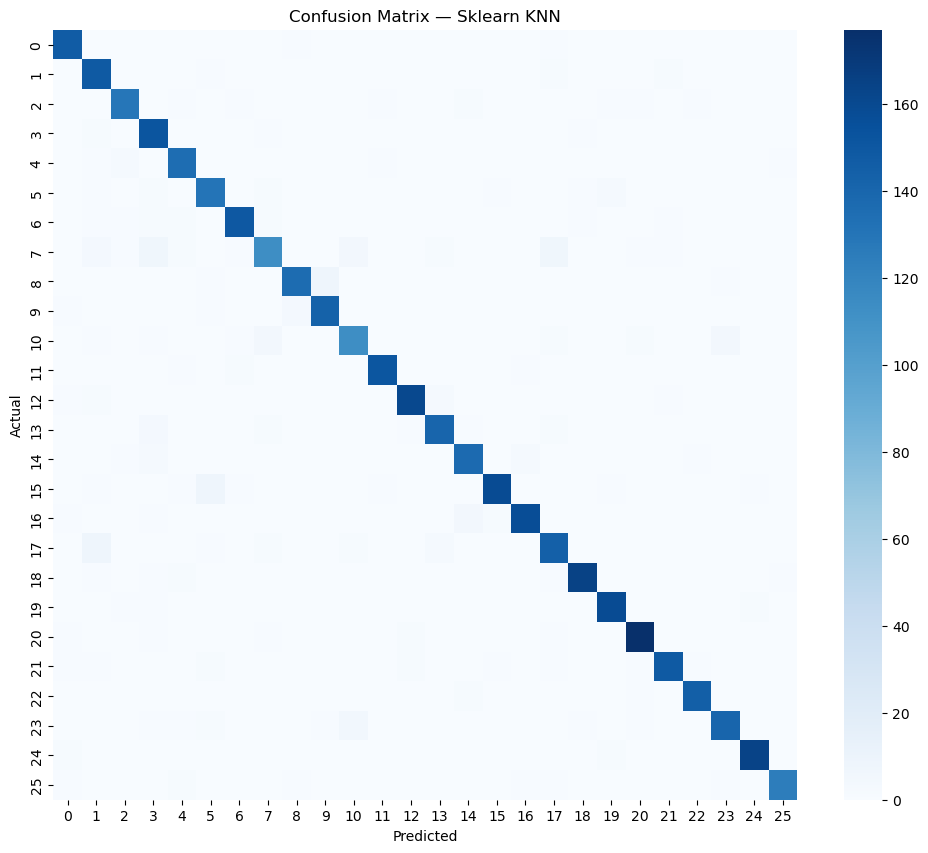

In [17]:
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_test, y_pred_sklearn), annot=False, cmap="Blues")
plt.title("Confusion Matrix — Sklearn KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
